In [1]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import time
from sortedcontainers import SortedSet # Used for fringe in A star
import queue
from collections import deque 
import seaborn as sns
import pandas as pd
import pickle

In [2]:
# Class cell -> its the class of all the nodes in the grid, Each cell of the grid is defined as a object of type 
# cell.
class cell:
    def __init__(self,x,y): # Constructor for class cell
        self.x = x # x coordinate of the cell
        self.y = y # y coordinate of the cell
        self.g = 0 # g value of the cell (the distance from start cell to curr cell)
        self.h = 0 # h value of the cell (estimated value of the distance between curr cell and goal cell)
        self.f = 0 # f value of the cell (f = g+h in A*, defines the priority of a node)
        self.blocked = False # Flag used to tell weather a cell is blocked or not
        self.terrain = None # If the cell is unblocked this flag stores the terrain type of the cell it is either of hilly, flat or forest.
        self.false_neg_rate = 0 # Depending on the terrain this variable stores the false negative rate of the cell
        self.prob_of_containing_target = 0 # This variable stores the probability of the cell x,y containing the target
        
    def set_h_value(self, g_x, g_y, heuristic, weight):
        '''This function is used to assign the heuristic value i.e. the h value and the f value to the calling 
           class object. It takes in the argument g_x = goal cell abscissa, g_y = goal cell ordinate, 
           heuristic = It defines the type of heuristic the A* problem is using, weight = this is for problem 
           number 9 (project 1) where we test the effect of weights on the performance of repeated A* and normal A*.
           In this project we have only used the manhattan distance as our heuristic.'''
        if heuristic == 'm': 
            # Manhattan distance
            self.h = weight * abs(g_x - self.x) + abs(g_y - self.y) # calculate the h value
            self.f = self.g + self.h # also updating f inside this function

In [3]:
# Class grid_world -> This class is used to generate a grid world of dimension dim with each cell having 
# probability p of being blocked.
class grid_world:
    def __init__(self,p,dim):
        self.p = p # probability with which the cell is blocked
        self.dim = dim # dimension of the grid (dim x dim)
    def gen_grid(self,matrix):
        '''This function is used to generate the grid. The grid is returned in the form of list of list.'''
        for i in range(self.dim): # looping over the dimension to generate rows of cells
            a = [] # store a row of the grid of len dim
            for j in range(self.dim): # looping over the dim to generate cols of cells
                c = cell(i,j) # cell for coordinates (i,j)
                chance = random.uniform(0,1) 
                # generating a random number between 0 and 1 from uniform distribution, if its less than p 
                # the cell is blocked else the cell is unblocked.
                # if the number generated is less than or equal to p, block the cell.
                if(chance <= self.p):
                    c.blocked = True
                else:
                    # If the cell is unblocked and you are not making the bot_env or the final_disc_gridworld assign the terrain type to the cell.
                    if(self.p!= 1 and self.p!= 0):
                        # To assign the terrain type randomly generate a integer in the range [1,3] and assign terrain corresponding to that number.
                        x = random.randint(1,3) # We use random.randint as there is a equally likely possibility of all three integers coming
                        if(x==1): # If the number is 1 assign terrain flat and false negative rate as 0.2.
                            c.terrain = 'flat' 
                            c.false_neg_rate = 0.2
                        elif x == 2: # If the number is 2 assign terrain hill and false negative rate as 0.5
                            c.terrain = 'hill'
                            c.false_neg_rate = 0.5
                        else: # If the number is 3 assign terrain forest and false negative rate as 0.8
                            c.terrain = 'Forest'
                            c.false_neg_rate = 0.8
                    
                a.append(c) # append the cell to the row
                
            matrix.append(a) # append the row to the grid
        if(self.p!= 1 and self.p!= 0): # If the grid we are generating is the real world grid
            while(True): # keep randomly choosing start cell and goal cell indices until both lie on unblocked cells.
                start_cell_x = random.randint(0,self.dim-1) # randomly select x coordinate of start cell
                start_cell_y = random.randint(0,self.dim-1) # randomly select y coordinate of start cell

                if matrix[start_cell_x][start_cell_y].blocked == True: # If the selected coordinate is blocked continue 
                    # and reselect the start cell coordinate
                    continue

                target_x = random.randint(0,self.dim-1) # Select the x coordinate of target cell
                target_y = random.randint(0,self.dim-1) # Select the y coordinate of target cell

                if matrix[target_x][target_y].blocked == True: # If the selected coordinate is blocked continue.
                    continue

                break # If both the index lie on unblocked cells break the loop.
        
            return matrix, (start_cell_x, start_cell_y), (target_x, target_y) # return the final grid, start cell index and goal cell index in case of real_world_grid
        else:
            return matrix # Simply return the grid in case of bot_env and final_disc_gridworld.

In [4]:
def gen_env(p, dim):
    '''Function to generate the enviornment with probability of blockage p and dimension = dim x dim'''
    temp = grid_world(p, dim)
    if (p!= 1 and p!= 0):
        grid, start_cell_ind, target_ind = temp.gen_grid([])
        return grid, start_cell_ind, target_ind
    else:
        grid = temp.gen_grid([])
        return grid

In [5]:
def disp_grid(grid):
    '''Since our grid is a list of list of cells simply printing it does not work. This function prints the 
    grid with blockage as x and a cell on which we can travel as -'''
    l = []
    for i in range(len(grid)):
        a = []
        for j in range(len(grid)):
            if grid[i][j].blocked:
                a.append('x')
            else:
                a.append('-')
        l.append(a)
    return l

In [6]:
def find_target_in_goal_cell(grid,cell_x,cell_y,target_cell):
    if((cell_x, cell_y) == target_cell):
        chance = random.uniform(0,1)
        if chance <= grid[cell_x][cell_y].false_neg_rate:
            return False
        else:
            return True
    else:
        return False

In [7]:
#function to print path
def print_path(paths, start_cell_ind):
    '''
    Function to print the path also we use it to get the final trajectory with backtracking taken by the agent. 
    '''
    l = [list(start_cell_ind)] # start from [0,0]
    for path in paths: 
        l.extend(path[1:]) # extend the list with values of path 
    return l

In [8]:
def is_solvable(grid,start_cell_ind,target_ind):
    '''Function to check the solvability of the grid.'''
    p = Astar(real_world_grid,start_cell_ind,target_ind,'m')
    if p[0] == []:
        return False
    else:
        return True

In [9]:
def Astar(grid,start_cell_ind,goal_cell_ind, heuristic, weight = 1):
    cells_processed = 0 # number of cells popped from the fringe before reaching the goal.
    number_of_clashes = 0 # number of time we had to update priorities in the fringe.
    start_cell = grid[start_cell_ind[0]][start_cell_ind[1]] # start cell of our grid.
    goal_cell = grid[goal_cell_ind[0]][goal_cell_ind[1]] # goal cell of our grid
    open_list = SortedSet() # fringe, we have used sorted set as our priority queue
    close_list = set() # contains cells already processed, have used set for this purpose (O(1) lookup on average)
    parent_dict = {} # stores parent child relationship, using dictionary for this
    visited = set() # child already visited, using set for this purpose (O(1) lookup on average)
    start_cell.g = 0 # Setting the g value of the start cell to 0
    # setting the h and f value of the start cell using the weight and heuristic passed in the function arguments.
    # weight is for q9
    start_cell.set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
    open_list.add((start_cell.f, start_cell.h, (start_cell.x, start_cell.y))) # adding the start cell to the priority queue
    # In the queue we are pushing a tuple whose first coordinate is the f value, second coordinate is the h value 
    # then a tuple containing the location of the cell. The priority is set according to the f value in case of a 
    # tie h value is seen.
    visited.add((start_cell.x, start_cell.y)) # updating the visited set as we are pushing the node in priority queue
    while len(open_list)>0: # loop over the priority queue until it is not empty or we reach the goal node
        cl = open_list.pop(0) # pop the node with the least priority (it is at index 0 in the sorted set)
        curr_cell = grid[cl[-1][0]][cl[-1][1]] # the last index in cl contains the x and y coordinates, 
        # storing the node popped from the queue in curr_cell.
        cells_processed += 1 # incrementing the number of cells processed (since we just popped from the queue)
        close_list.add((curr_cell.x, curr_cell.y)) # adding the node to the closed list as it is about to be processed
        if curr_cell == goal_cell: 
            # If the curr cell is the goal cell return the path from the curr cell to goal cell by backtracking 
            # from goal cell to curr cell using the parent dictionary as well as all the nodes 
            # that have been processed uptil now.
            path = []
            curr = curr_cell
            while (curr.x, curr.y) != (start_cell_ind[0], start_cell_ind[1]):
                path.append([curr.x, curr.y])
                curr = parent_dict[(curr.x, curr.y)]
            path.append([curr.x,curr.y])
            return path[::-1], cells_processed, number_of_clashes
        
        children = [] # This list is used to store all the possible valid children of the cell 
        # currently being processed.
        for new_pos in [(0,1),(0,-1),(1,0),(-1,0)]: # 4 main compass directions, field of view also the agent can 
            # only move to these locations
            node_pos = (curr_cell.x+new_pos[0], curr_cell.y+new_pos[1]) # position of the child
            if(node_pos[0] > len(grid)-1 or node_pos[1] > len(grid)-1 or node_pos[0] < 0 or node_pos[1] < 0):
                # if the child is not part of the grid continue
                continue
            if(grid[node_pos[0]][node_pos[1]].blocked):
                # if the child is blocked continue
                continue
            if((node_pos[0], node_pos[1]) in close_list):
                # if child is in close list continue
                continue
            if((node_pos[0], node_pos[1]) in visited):
                # if the child is already visited then compare the previous cost(f) to the new cost(f) and if the
                # new cost is lower update the priority of the child in the priority queue, update the 
                # parent dictionary and update the g value of the node.
                if curr_cell.g + 1 + grid[node_pos[0]][node_pos[1]].h < grid[node_pos[0]][node_pos[1]].f:
                    number_of_clashes += 1 # increment the number of clashes by 1
                    # To update the priority we remove the node from the sorted set (O(logn)) and reinsert with 
                    # new priority O(log(n)). 
                    open_list.remove((grid[node_pos[0]][node_pos[1]].f, grid[node_pos[0]][node_pos[1]].h, (grid[node_pos[0]][node_pos[1]].x, grid[node_pos[0]][node_pos[1]].y)))
                    grid[node_pos[0]][node_pos[1]].g = curr_cell.g+1
                    grid[node_pos[0]][node_pos[1]].set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
                    open_list.add((grid[node_pos[0]][node_pos[1]].f, grid[node_pos[0]][node_pos[1]].h, (grid[node_pos[0]][node_pos[1]].x, grid[node_pos[0]][node_pos[1]].y)))
                    parent_dict[(node_pos[0],node_pos[1])] = curr_cell # updating the parent dictionary
            else:
                # If the child is not visited update its g value, set its h and f value and add it to the 
                # children list after updating its parent.
                grid[node_pos[0]][node_pos[1]].g = curr_cell.g + 1
                grid[node_pos[0]][node_pos[1]].set_h_value(goal_cell_ind[0], goal_cell_ind[1], heuristic, weight)
                children.append(grid[node_pos[0]][node_pos[1]])
                parent_dict[(node_pos[0],node_pos[1])] = curr_cell
        if(children == []): # If no valid child continue
            continue
        for child in children: # else if valid children exist add them to the open list and update the visited set.
            open_list.add((child.f,child.h, (child.x, child.y)))
            visited.add((child.x, child.y))
    
    return [], 0, 0

### Agent 9

In [10]:
# function to implement the A* algorithm
def repeated_astar_agent9(bot_env, real_world_grid, start_cell_ind,target_cell_ind, heuristic, final_discovered_grid_world, weight=1):
    '''
    This function is the implementation of the repeated A* algorithm. This function calls A* algorithm whenver a 
    blocked cell is encountered along the path returned by A*.
    '''
    count = 0
    paths = [] # stores the path to be returned.
    cp = 0  # keeps count of the total number of cells processed in each A* call.
    #while the A* algorithm doesn't return a path or the maze is found to be not solvable     
    planning_time = 0
    track_states = []
    nodes_disc = 0
    belief = gen_initial_belief_matrix(len(bot_env))
    candidate_targets = choose_next_goal_cell_agent9(bot_env, start_cell_ind[0], start_cell_ind[1], belief)
    tar_ind = random.choice(candidate_targets)
    goal_cell_ind = tar_ind
    examine_cost = 0
    movement_cost = 0
    do_not_move = False
    sensed = False
    prev_start_cell_ind = start_cell_ind
    while(1):
        count += 1
        if(count != 1):
            if do_not_move:
                do_not_move = False
            else:
                target_cell_ind = move_target(real_world_grid,target_cell_ind[0], target_cell_ind[1])
        track_states.append((start_cell_ind, goal_cell_ind))
        if(len(track_states)>=20):
            flag = True
            for i in range(len(track_states)-2):
                if(track_states[i] != track_states[i+2]):
                    flag = False
            if(flag):
#             if(track_states[-1] == track_states[-3] and track_states[-2] == track_states[-4]):
                start_cell_ind = move_agent_randomly(start_cell_ind)
                movement_cost += 1
                target_cell_ind = move_target(real_world_grid, target_cell_ind[0], target_cell_ind[1])
                continue
            track_states =[]
        t = time.time()
        path, cells_processed, n_c = Astar(bot_env, start_cell_ind, goal_cell_ind, heuristic, weight) # call A* with current knowledge of the grid
        planning_time += time.time() - t
        cp += cells_processed # add the number of cells processed to the variable cp which keeps the total number of cells processed for each iteration of A*
        
        if(path == []): # If A* doesn't return a path, path doesn't exist. Break from the loop and print "Maze is not solvable"
            bot_env[goal_cell_ind[0]][goal_cell_ind[1]].blocked = True
            bot_env[goal_cell_ind[0]][goal_cell_ind[1]].terrain = None
            bot_env[goal_cell_ind[0]][goal_cell_ind[1]].false_neg_rate = 0
            
            assign_new_probability_when_new_block_disc_agent9(bot_env,belief,goal_cell_ind[0],goal_cell_ind[1])
            candidate_targets = choose_next_goal_cell_agent9(bot_env,start_cell_ind[0],start_cell_ind[1], belief)
            tar_ind = random.choice(candidate_targets)
            goal_cell_ind = tar_ind
            do_not_move = True
            continue
            
        else:  # If path exists, do this:
            params = explore_path_with_limited_view_agent9(path,bot_env,real_world_grid,examine_cost,target_cell_ind, movement_cost, belief, prev_start_cell_ind)
            p = params[0]
            paths.append(p)  # append the path returned to paths  
            
            belief = params[-2]
            sensed = params[-3]
            prev_start_cell_ind = params[-1]
            
            if (params[1] == True):
                start_cell_ind = prev_start_cell_ind
            else:
                start_cell_ind = p[-1]
            goal_cell_ind = params[2]
            examine_cost = params[3]
            if sensed == False and params[1] == False:
                movement_cost = params[4]
                
            if sensed == True:
                while(sense_target(target_cell_ind, start_cell_ind)):
                    target_cell_ind = move_target(real_world_grid, target_cell_ind[0], target_cell_ind[1])
                    continue
                examine_cost += 1
                if(find_target_in_goal_cell(bot_env, start_cell_ind[0], start_cell_ind[1], target_cell_ind)):
                    return paths, examine_cost, movement_cost
                else:
                    sensed = False
                    do_not_move = True
                    belief = predict_one_step(bot_env, belief)
                    candidate_targets = choose_next_goal_cell_agent9(bot_env,start_cell_ind[0],start_cell_ind[1], belief)
                    tar_ind = random.choice(candidate_targets)
                    new_goal_cell = tar_ind

In [11]:
#function to explore path returned by A* algorithm with limited field of view (the bot can only see in the direction of its movement along the path). 
def explore_path_with_limited_view_agent9(path, bot_env, grid, examine_cost, target_cell_ind, movement_cost, belief, previous_start_cell):
    '''
    This function helps move the agent along the path returned by A* with unidirectional field of view. The bot environment
    and final discovered grid world are updated with status of cells along the path traversed.
    '''
    x = 0
    y = 0
    sensed = False
    for i in range(len(path)): #looping over path list                
        x = path[i][0] # x coordinate of the current node
        y = path[i][1] # y coordinate of the current node
        movement_cost += 1
        #update the bot environment and final discovered grid 
        bot_env[x][y].x = grid[x][y].x 
        bot_env[x][y].y = grid[x][y].y
        bot_env[x][y].blocked = grid[x][y].blocked
        bot_env[x][y].terrain = grid[x][y].terrain
        bot_env[x][y].false_neg_rate = grid[x][y].false_neg_rate
        
        if(grid[x][y].blocked): #if the current node is blocked node, return the path traversed till now.
            movement_cost -= 1
            belief = assign_new_probability_when_new_block_disc_agent9(bot_env,belief,x,y)
            candidate_targets = choose_next_goal_cell_agent9(bot_env,path[i-1][0],path[i-1][1], belief)
            tar_ind = random.choice(candidate_targets)
            new_goal_cell = tar_ind
            return path[:i], True ,new_goal_cell, examine_cost, movement_cost, sensed, belief, previous_start_cell
    
        if(sense_target(target_cell_ind, (x,y)) == False):
            belief = update_prob(bot_env, belief, False, (x,y))
            predict = predict_one_step(bot_env, belief)
            belief = predict
            candidate_targets = choose_next_goal_cell_agent9(bot_env,path[i][0],path[i][1], belief)
            tar_ind = random.choice(candidate_targets)
            new_goal_cell = tar_ind
            sensed = False
            return path[:i+2], False ,new_goal_cell, examine_cost, movement_cost, sensed, belief, path[:i+1][0]
            
        else:
            belief = update_prob(bot_env, belief, True, (x,y))
            predict = predict_one_step(bot_env, belief)
            belief = predict
            candidate_targets = choose_next_goal_cell_agent9(bot_env,path[i][0],path[i][1], belief)
            tar_ind = random.choice(candidate_targets)
            new_goal_cell = tar_ind
            sensed = True
            return path[:i+1], False ,new_goal_cell, examine_cost, movement_cost, sensed, belief, previous_start_cell

In [12]:
def move_agent_randomly(start_cell_ind):
    node_pos = [(-1,0), (0,-1), (1,0), (0,1)]
    children = []
    for i in node_pos:
        x_idx = start_cell_ind[0]+i[0]
        y_idx = start_cell_ind[1]+i[1]
        if(x_idx<len(real_world_grid) and x_idx>=0 and y_idx<len(real_world_grid) and y_idx>=0):
            if(real_world_grid[x_idx][y_idx].blocked == False):
                children.append((x_idx, y_idx))
    idx = random.randint(0, len(children)-1)
    return children[idx]

In [13]:
def assign_new_probability_when_new_block_disc_agent9(grid,belief, cell_x, cell_y):
    prob_of_containing_x_y = belief[cell_x][cell_y]
    den = 0
    
    for i in range(len(grid)):
        for j in range(len(grid)):
            if(grid[i][j].blocked):
                continue
            if(i==cell_x and j == cell_y):
                continue
            else:
                den += belief[i][j]
    
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if (i== cell_x and j== cell_y):
                belief[i][j] = 0
            else:
                if(grid[i][j].blocked):
                    continue
                else:
                    belief[i][j]= belief[i][j]/den
    return belief

In [14]:
def choose_next_goal_cell_agent9(grid, cell_x, cell_y, belief):
    min_dist = math.inf
    target = []
    max_utility = 0
    max_utility_ind = []
    max_dist = 200
    
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            if(i==cell_x and j == cell_y):
                continue
            p = belief[i][j]
            FN = grid[i][j].false_neg_rate
            dist = abs(cell_x - i) + abs(cell_y - j)
            if p*(1-FN)*max_dist/dist > max_utility:
                max_utility = p*(1-FN)*max_dist/dist
                max_utility_ind = [[i,j]]
            elif p*(1-FN)*max_dist/dist == max_utility:
                max_utility_ind.append([i,j])    

    for l in max_utility_ind:
        if abs(cell_x - l[0]) + abs(cell_y - l[1]) < min_dist:
            min_dist = abs(cell_x - l[0]) + abs(cell_y - l[1])
            target = [l]
        elif abs(cell_x - l[0]) + abs(cell_y - l[1]) == min_dist:
            target.append(l)
    return target

In [15]:
def move_target(real_world_grid, x, y):
    node_pos = [(-1,0), (0,-1), (1,0), (0,1)]
    children = []
    for i in node_pos:
        x_idx = x+i[0]
        y_idx = y+i[1]
        if(x+i[0]<len(real_world_grid) and x+i[0]>=0 and y+i[1]<len(real_world_grid) and y+i[1]>=0):
            if(real_world_grid[x_idx][y_idx].blocked == False):
                children.append((x+i[0], y+i[1]))
    idx = random.randint(0, len(children)-1)
    return children[idx]

In [16]:
def sense_target(target, agent):
    if(abs(target[0]-agent[0])<=1 and abs(target[1]-agent[1])<=1 and target!=agent):
        if(abs(target[0]-agent[0])==0 and abs(target[1]-agent[1])==0):
            return False
        return True
    return False

In [17]:
def gen_initial_belief_matrix(dim):
    belief = []
    for i in range(dim):
        row = []
        for j in range(dim):
            prob = 1/(dim*dim)
            row.append(prob)
        belief.append(row)
    return belief

In [18]:
def count_unblocked_neighbours(bot_env, pos):
    node_pos = [(-1,0), (0,-1), (1,0), (0,1)]
    children = []
    cnt = 0
    for i in node_pos:
        x_idx = pos[0]+i[0]
        y_idx = pos[1]+i[1]
        if(x_idx<len(real_world_grid) and x_idx>=0 and y_idx<len(real_world_grid) and y_idx>=0):
            if(bot_env[x_idx][y_idx].blocked == False):
                cnt+=1
    return cnt

In [19]:
def predict_one_step(bot_env, belief):
    predict = []
    for i in range(len(belief)):
        a = []
        for j in range(len(belief)):
            pred = 0
            if(bot_env[i][j].blocked):
                a.append(pred)
                continue
            neighbours = [(0,1), (1,0), (0,-1), (-1,0)]
            for node in neighbours:
                if(node[0]+i < len(bot_env) and node[0]+i >= 0 and node[1]+j >=0 and node[1]+j < len(bot_env)):
                    if(bot_env[node[0]+i][node[1]+j].blocked):
                        continue
                    neighbour = (node[0]+i, node[1]+j)
                    num_of_unblocked = count_unblocked_neighbours(bot_env, neighbour)
                    if (num_of_unblocked == 0):
                        pred += 0
                    else:
                        pred += 1/(num_of_unblocked) * belief[neighbour[0]][neighbour[1]]
            a.append(pred)
        predict.append(a)
    return predict

In [20]:
def update_prob(bot_env, belief, in_vicinity, pos):
    prob_total = 0
    children = []
    if(in_vicinity == False):
        node_pos = [(0,1),(1,0), (0,-1), (-1,0), (1,1), (-1,-1), (1,-1), (-1,1)]
        for node in node_pos:
            if(node[0]+pos[0] < len(bot_env) and node[0]+pos[0] >= 0 and node[1]+pos[1] >= 0 and node[1]+pos[1] < len(bot_env) and bot_env[node[0]+pos[0]][node[1]+pos[1]].blocked == False):
                prob_total += belief[node[0]+pos[0]][node[1]+pos[1]]
                children.append((node[0]+pos[0], node[1]+pos[1]))
                belief[node[0]+pos[0]][node[1]+pos[1]] = 0
        for i in range(len(belief)):
            for j in range(len(belief)):
                if((i,j) not in children and bot_env[i][j].blocked == False):
                    belief[i][j] = belief[i][j]/(1-prob_total)
    else:
        node_pos = [(0,1),(1,0), (0,-1), (-1,0), (1,1), (-1,-1), (1,-1), (-1,1)]
        children = []
        for node in node_pos:
            if(node[0]+pos[0] < len(bot_env) and node[0]+pos[0] >= 0 and node[1]+pos[1] >= 0 and node[1]+pos[1] < len(bot_env) and bot_env[node[0]+pos[0]][node[1]+pos[1]].blocked == False):
                children.append((node[0]+pos[0], node[1]+pos[1]))
        number_of_children = len(children)
        for i in range(len(belief)):
            for j in range(len(belief)):
                if((i,j) not in children and bot_env[i][j].blocked == False):
                    belief[i][j] = 0
                elif((i,j) in children):
                    belief[i][j] = 1/number_of_children
    return belief

In [21]:
real_world_grid, start_cell_ind, target_ind = gen_env(0.3,50)

In [22]:
real_world_grid, start_cell_ind, target_ind = gen_env(0.3,50)

In [23]:
bot_env = gen_env(0,50)

In [24]:
final_discovered_gridworld = gen_env(1,50)

In [25]:
start_cell_ind

(42, 29)

In [26]:
target_ind

(44, 20)

In [27]:
is_solvable(real_world_grid,start_cell_ind,target_ind)

True

In [28]:
bot_env = gen_env(0,50)

In [29]:
final_discovered_gridworld = gen_env(1,50)

In [30]:
count = 0
cost_agent_9 = []
movement_cost_agent_9 = []
examination_cost_agent_9 = []

pbar = tqdm(total=100)
while(count < 100):
    real_world_grid, start_cell_ind, target_ind = gen_env(0.3,50)
    if is_solvable(real_world_grid, start_cell_ind, target_ind):
        count += 1
    else:
        continue
    
    bot_env = gen_env(0,50)
    final_discovered_grid_world = gen_env(1,50)
    output = repeated_astar_agent9(bot_env,real_world_grid,start_cell_ind,target_ind, 'm', final_discovered_gridworld)
    cost_agent_9.append(output[1]+output[2])
    movement_cost_agent_9.append(output[2])
    examination_cost_agent_9.append(output[1])
    pbar.update(1)
pbar.close()

 34%|███▍      | 34/100 [27:27<48:52, 44.43s/it]  

ZeroDivisionError: float division by zero

In [ ]:
sum(cost_agent_9)/100

In [ ]:
sum(movement_cost_agent_9)/100

In [ ]:
sum(examination_cost_agent_9)/100

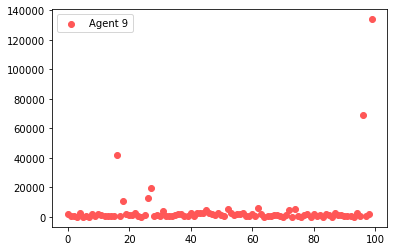

In [284]:
plt.scatter(range(100),cost_agent_9,c='#FF5757')
plt.legend(['Agent 9'])

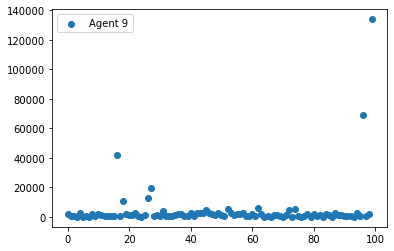

In [285]:
plt.scatter(range(100),movement_cost_agent_9)
plt.legend(['Agent 9'])

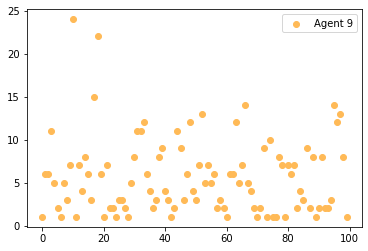

In [286]:
plt.scatter(range(100),examination_cost_agent_9,c='#FFBA57')
plt.legend(['Agent 9'])

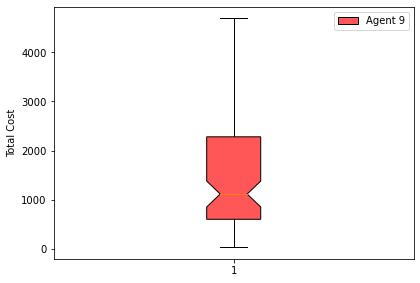

In [276]:
np.random.seed(10) 
data = [cost_agent_9] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#FF5757'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0]], ['Agent 9'])
# show plot
plt.ylabel('Total Cost')
plt.show() 

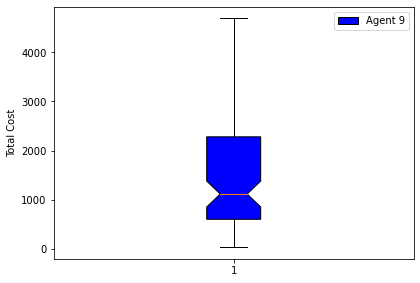

In [296]:
np.random.seed(10) 
data = [cost_agent_9] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['b'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0]], ['Agent 9'])
# show plot
plt.ylabel('Total Cost')
plt.show() 

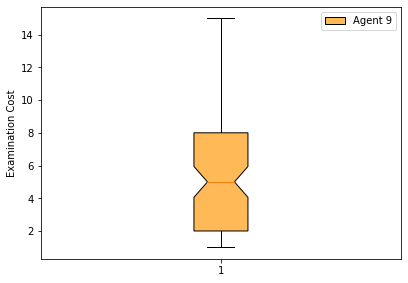

In [295]:
np.random.seed(10) 
data = [examination_cost_agent_9] 
   
fig = plt.figure(figsize =(10, 7)) 
   
# Creating axes instance 
ax = fig.add_axes([0, 0, 0.5, 0.5]) 
   
# Creating plot 
bp = ax.boxplot(data, showfliers=False, notch=True, patch_artist = True) 

colors = ['#FFBA57'] 
   
for patch, color in zip(bp['boxes'], colors): 
    patch.set_facecolor(color) 
    
ax.legend([bp["boxes"][0]], ['Agent 9'])
# show plot
plt.ylabel('Examination Cost')
plt.show() 

In [265]:
import pickle

In [266]:
with open('total_cost_agent_9.pkl', 'wb') as f:
    pickle.dump(cost_agent_9,f)

In [267]:
with open('movement_cost_agent_9.pkl', 'wb') as f:
    pickle.dump(movement_cost_agent_9,f)

In [268]:
with open('examination_cost_agent_9.pkl', 'wb') as f:
    pickle.dump(examination_cost_agent_9,f)